In [ ]:
!git clone https://github.com/vanshdhar999/TransApp.git

Cloning into 'TransApp'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (326/326), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 738 (delta 147), reused 311 (delta 141), pack-reused 412 (from 1)
Receiving objects: 100% (738/738), 506.04 MiB | 22.06 MiB/s, done.
Resolving deltas: 100% (300/300), done.
Updating files: 100% (144/144), done.


In [ ]:
# Change to the cloned repository directory
import os
import sys
from pathlib import Path
os.chdir('/content/TransApp')  # Replace with your actual repo name

# Add the repo root to Python path
root = Path(os.getcwd()).resolve()
sys.path.append(str(root))

In [ ]:
!pip install torchinfo

In [ ]:
import os, sys
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

root = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(root))
from experiments.data_utils import *
from src.TransAppModel.TransApp import *
from src.AD_Framework.Framework import *
from src.utils.losses import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

In [ ]:
def get_model_inst(m, win, dim_model, mode="pretraining", large_version=False, path_select_core=None):
    """
    Description:
        Get TransApp model instance

    Parameters:
        m: int - n channel of input time series
        win: int - length of input subsequence (usefull for positional encoding, if any)
        mode: str - 'pretraining' or 'classif' (type of head)
        large_version: boolean - if true, use 5 encoder layers instead of 3
        path_select_core: str - path to pretrained instance of TransApp
    """

    TApp = TransApp(max_len=win, c_in=m,
                    mode=mode,
                    n_embed_blocks=1,
                    encoding_type='noencoding',
                    n_encoder_layers=5 if large_version else 3,
                    kernel_size=5,
                    d_model=dim_model, pffn_ratio=2, n_head=4,
                    prenorm=True, norm="LayerNorm",
                    activation='gelu',
                    store_att=False, attn_dp_rate=0.2, head_dp_rate=0., dp_rate=0.2,
                    att_param={'attenc_mask_diag': True, 'attenc_mask_flag': False, 'learnable_scale_enc': False},
                    c_reconstruct=1, apply_gap=True, nb_class=2)

    if path_select_core is not None:
        TApp.load_state_dict(torch.load(path_select_core)['model_state_dict'])

    return TApp

In [ ]:
m       = 5    # Number of channel of the input time series (i.e. consumption time series, hours encoded in sin/cos based , days encoded in sin/cos based)
win     = 1024 # Choseen length of slicing window size
d_model = 96   # Inner dimension of the model

TransAppInstance = get_model_inst(m=m, win=win, dim_model=d_model, mode="pretraining") # Pretraining mode of our TransApp model

In [ ]:
data_pretraining = CER_get_data_pretraining(exo_variable=['hours_cos', 'hours_sin', 'days_cos', 'days_sin'])

In [ ]:
summary(TransAppInstance, input_size=(1, m, win), mode="train", device='cpu') # show TransApp architecture with pretraining head

Layer (type:depth-idx)                                  Output Shape              Param #
TransApp                                                [1, 1, 1024]              194
├─Sequential: 1-1                                       [1, 1024, 96]             --
│    └─DilatedBlock: 2-1                                [1, 96, 1024]             --
│    │    └─Sequential: 3-1                             [1, 96, 1024]             142,368
│    └─Transpose: 2-2                                   [1, 1024, 96]             --
├─Sequential: 1-2                                       [1, 1024, 96]             --
│    └─EncoderLayer: 2-3                                [1, 1024, 96]             --
│    │    └─LayerNorm: 3-2                              [1, 1024, 96]             192
│    │    └─AttentionLayer: 3-3                         [1, 1024, 96]             37,248
│    │    └─LayerNorm: 3-4                              [1, 1024, 96]             192
│    │    └─PositionWiseFeedForward: 3-5        

In [ ]:
dict_params = {'lr': 1e-4, 'wd': 1e-4, 'batch_size': 16, 'epochs': 10}
save_path = str(root) + '/tmp/TransAppPT' # Model save path

pretraining_dataset = TSDataset(data_pretraining, scaler=True, scale_dim=[0])
train_loader = torch.utils.data.DataLoader(pretraining_dataset, batch_size=dict_params['batch_size'], shuffle=True)

GeomMask = GeometricMask(mean_length=24, masking_ratio=0.5, type_corrupt='zero', dim_masked=0) # Mask to corrupt inout time series

model_pretrainer = self_pretrainer(TransAppInstance,
                                   train_loader, valid_loader=None,
                                   learning_rate=dict_params['lr'], weight_decay=dict_params['wd'],
                                   name_scheduler='CosineAnnealingLR',
                                   dict_params_scheduler={'T_max': dict_params['epochs'], 'eta_min': 1e-6},
                                   warmup_duration=None,
                                   criterion=MaskedMSELoss(type_loss='L1'), mask=GeomMask,
                                   device="cuda", all_gpu=False,
                                   verbose=True, plotloss=True,
                                   save_fig=False, path_fig=None,
                                   save_only_core=False,
                                   save_checkpoint=True, path_checkpoint=save_path)

Epoch [1/10]
    Train loss : 0.485115
Epoch [2/10]
    Train loss : 0.460213
Epoch [3/10]
    Train loss : 0.455443
Epoch [4/10]
    Train loss : 0.453016
Epoch [5/10]
    Train loss : 0.451065
Epoch [6/10]
    Train loss : 0.449562
Epoch [7/10]
    Train loss : 0.448676
Epoch [8/10]
    Train loss : 0.447711
Epoch [9/10]
    Train loss : 0.447295
Epoch [10/10]
    Train loss : 0.447251


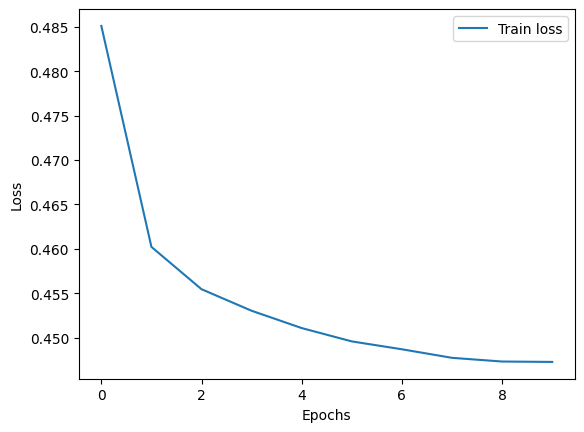

In [ ]:
model_pretrainer.train(dict_params['epochs'])